# Derive waterbody relative topography using Landsat

This notebook demonstrates how to load Landsat time series data, compute a water index, generate a rolling median water index composites, extract contours along the land-water boundary, and finally interpolate between contours to produce a 3D relative topographic surface. This relative topography could be easily calibrated to obtain absolute bathymetry (and accordingly, volume estimates) with a simple GPS transect from the highest to the deepest part of the lake during a dry period.

**Author**: Robbi Bishop-Taylor

**Date**: 30 October 2018

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import datacube
import glob
import rasterio
import scipy
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_display_map import display_map

from ga_utils import contour_extract
from ga_utils import contours_to_arrays
from ga_utils import interpolate_timeseries

dc = datacube.Datacube(app = 'my_app')

%load_ext autoreload
%autoreload 2

## Set up analysis

In [2]:
# Define satellite data to import
platform = "LANDSAT_8"
product = "ls8_usgs_sr_scene"  # "ls8_lasrc_kenya"

# Contour extraction and interpolation parameters
min_vertices = 5  # This can be used to remove noise by dropping contours with less than X vertices
guassian_sigma = 0  # Controls amount of smoothing to apply to interpolated raster. Higher = smoother


In [3]:
# # Lake Sulunga
# name = 'sulunga'
# product = "ls8_lasrc_tanzania" 
# frac_res = 0.5 # This saves memory by reducing data resolution
# latitude_extents = (-5.86, -6.27) 
# longitude_extents = (34.97, 35.38)
# time_extents = ('2013-01-01', '2018-11-01')

# # Lake Balangida
# name='balangida'
# product = "ls8_lasrc_tanzania" 
# frac_res = 0.5 
# latitude_extents = (-4.60, -4.76)
# longitude_extents = (35.135, 35.295)
# time_extents = ('2013-01-01', '2018-11-01')

# # Lake Nakuru
# name = 'nakuru'
# product = "ls8_lasrc_kenya" 
# frac_res = 1.0 
# latitude_extents = (-0.30, -0.42) 
# longitude_extents = (36.05, 36.13)
# time_extents = ('2013-01-01', '2018-11-01')

# Lake in Singida, Tanzania
name='singida'
product = "ls8_usgs_sr_scene" 
frac_res = 1.0
latitude_extents = (-4.665, -4.751)
longitude_extents = (34.80, 34.885)
time_extents = ('2013-01-01', '2018-11-01')

# # Marigot de Bignone
# name='marigotdebignone'
# product = "ls8_lasrc_senegal" 
# frac_res = 1.0
# longitude_extents = (-16.43, -16.21)
# latitude_extents = (12.83, 12.65)
# time_extents = ('2013-01-01', '2018-11-01')

display_map(latitude_extents, longitude_extents)

## Import Landsat data and mask by cloud

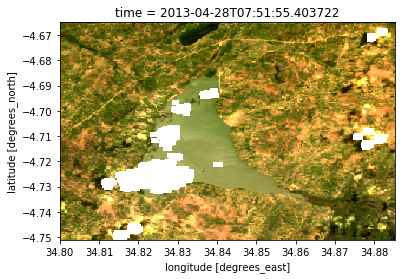

In [4]:
# Set up time, date and desired bands
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'swir1', 'pixel_qa'], 
                          time = time_extents,
                          output_crs = 'EPSG:4326', resolution = (-0.0003, 0.0003),
                          group_by = 'solar_day')

cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)


# Mask out cloudy pixels
landsat_dataset = landsat_dataset.where(cloud_mask)

# Plot single time step
landsat_dataset[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True)

### Compute water index for each timestep

In [5]:
# Calculate MNDWI water index (gives best results in turbid inland waters)
landsat_dataset['mndwi'] = ((landsat_dataset.green - landsat_dataset.swir1) / 
                            (landsat_dataset.green + landsat_dataset.swir1))
    
# landsat_dataset['ndwi'] = (landsat_dataset.green - landsat_dataset.nir) / \
#                            (landsat_dataset.green + landsat_dataset.nir)
    
# landsat_dataset['awei'] = (4 * (landsat_dataset.green * 0.0001 - landsat_dataset.swir1 * 0.0001) -
#                            (0.25 * landsat_dataset.nir * 0.0001 + 2.75 * landsat_dataset.swir2 * 0.0001))


## Compute percentages of valid data and inundation per timestep

In [6]:
# Create mask of max extent of water (land = 0, water = 1) and create new layer with
# NaN for all pixels outside max extent area
max_water_mask = ~((landsat_dataset.mndwi.fillna(-1) < 0).min(dim='time'))
mndwi_water_masked = landsat_dataset.mndwi.where(max_water_mask)

# Calculate the valid data percentage for each time step by dividing the number of 
# non-NaN pixels in timestep by the total number of pixels in the max extent water layer
landsat_dataset['data_perc'] = (mndwi_water_masked.count(dim=['longitude', 'latitude']) / 
                               (max_water_mask).sum())

# Calculate innundation percent
inundation_perc = ((mndwi_water_masked > 0).sum(dim=['longitude', 'latitude']) /  
                   mndwi_water_masked.count(dim=['longitude', 'latitude']))
landsat_dataset['inundation_perc'] = inundation_perc

# Sort in reverse order by inundation percentage (from wet to dry)
landsat_dataset = landsat_dataset.sortby('inundation_perc', ascending=False)


# Restrict to scenes with greater than 20% valid data and select variables for further analysis
to_keep = landsat_dataset.data_perc > 0.2
cleaned_subset = landsat_dataset[['mndwi', 'data_perc', 'inundation_perc']].sel(time = to_keep)


### Export time series

Interpolating 566 time-steps at 3D intervals


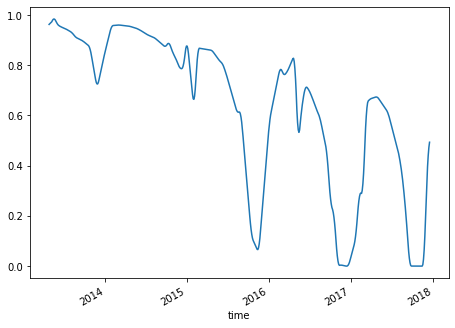

In [7]:
# Plot only observations with greater than 20% valid data
timeseries_subset = landsat_dataset.sel(time = to_keep).inundation_perc

# # Interpolate to one point per week, then take a rolling mean to smooth line for plotting
timeseries_subset = interpolate_timeseries(timeseries_subset.sortby('time'), freq='3D', method='linear')
timeseries_subset = timeseries_subset.rolling(time=5, min_periods=1).mean()
timeseries_subset.plot(size=5)

# Export to text file
timeseries_subset_df = timeseries_subset.to_dataframe(name='innundation_perc')
timeseries_subset_df['date'] = timeseries_subset_df.index.floor('d')
timeseries_subset_df.set_index('date')
timeseries_subset_df.to_csv('GA_outputs/{}_timeseries.csv'.format(name))


## Compute median NDWI composites using a rolling 20 observation median

In [8]:
cleaned_subset = cleaned_subset.sortby('inundation_perc', ascending=False)

timesteps = len(cleaned_subset.time)
print('{} timesteps in total'.format(timesteps))

# Create output list to hold NDWI median composites
out = []

for i in np.arange(0, timesteps, 5):
    
    # identify min and max index to extract rolling median
    min_index = max(i - 15, 0)
    max_index = min(i + 15, timesteps)
    print('Creating median NDWI composite using indices {} to {}'.format(min_index, max_index))
    
    # Take median of dates that match indexes and add to list
    median_dataset = cleaned_subset.isel(time=slice(min_index, max_index)).median(dim='time')
    out.append(median_dataset)
out

# Combine each median composite into a single xarray dataset
combined = xr.concat(out, dim='inundation_perc').sortby('inundation_perc')


81 timesteps in total
Creating median NDWI composite using indices 0 to 15
Creating median NDWI composite using indices 0 to 20
Creating median NDWI composite using indices 0 to 25
Creating median NDWI composite using indices 0 to 30
Creating median NDWI composite using indices 5 to 35
Creating median NDWI composite using indices 10 to 40
Creating median NDWI composite using indices 15 to 45
Creating median NDWI composite using indices 20 to 50
Creating median NDWI composite using indices 25 to 55
Creating median NDWI composite using indices 30 to 60
Creating median NDWI composite using indices 35 to 65
Creating median NDWI composite using indices 40 to 70
Creating median NDWI composite using indices 45 to 75
Creating median NDWI composite using indices 50 to 80
Creating median NDWI composite using indices 55 to 81
Creating median NDWI composite using indices 60 to 81
Creating median NDWI composite using indices 65 to 81


## Extract contours from each median composite observation


Exporting contour shapefile to GA_outputs/singida_0.331.shp

Exporting contour shapefile to GA_outputs/singida_10.827.shp

Exporting contour shapefile to GA_outputs/singida_20.68.shp

Exporting contour shapefile to GA_outputs/singida_28.286.shp

Exporting contour shapefile to GA_outputs/singida_45.263.shp

Exporting contour shapefile to GA_outputs/singida_56.179.shp

Exporting contour shapefile to GA_outputs/singida_61.969.shp

Exporting contour shapefile to GA_outputs/singida_66.381.shp

Exporting contour shapefile to GA_outputs/singida_71.39.shp

Exporting contour shapefile to GA_outputs/singida_78.082.shp

Exporting contour shapefile to GA_outputs/singida_82.175.shp

Exporting contour shapefile to GA_outputs/singida_86.425.shp

Exporting contour shapefile to GA_outputs/singida_89.734.shp

Exporting contour shapefile to GA_outputs/singida_91.341.shp

Exporting contour shapefile to GA_outputs/singida_93.034.shp

Exporting contour shapefile to GA_outputs/singida_93.947.shp

Exporting 

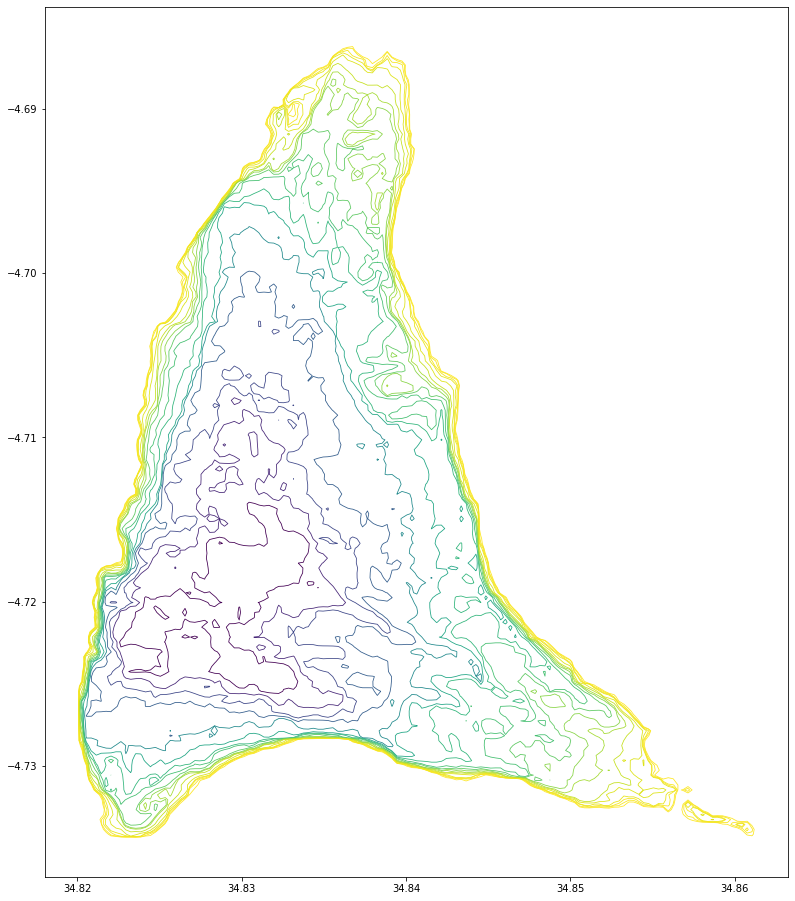

In [9]:
observations = combined.inundation_perc

for observation in observations:    

    cleaned_subset_i = combined.sel(inundation_perc=observation)
    
    # Compute area
    area = cleaned_subset_i.inundation_perc.item() * 100 
    
    # Prepare attributes as input to contour extract
    attribute_data = {'in_perc': [area]}
    attribute_dtypes = {'in_perc': 'float'}
    
    # Set threshold
    thresh = 0

    # Extract contours with custom attribute fields:
    contour_dict = contour_extract(z_values=[thresh],
                                   ds_array=cleaned_subset_i.mndwi,
                                   ds_crs='epsg:4326',
                                   ds_affine=landsat_dataset.geobox.transform,
                                   output_shp='GA_outputs/{}_{}.shp'.format(name, np.round(area, 3)),
                                   min_vertices=min_vertices,  
                                   attribute_data=attribute_data,
                                   attribute_dtypes=attribute_dtypes)

        
# Combine all shapefiles into one file
shapefiles = glob.glob('GA_outputs/{}_*.shp'.format(name))
gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles], sort=False).pipe(gpd.GeoDataFrame)

# Set CRS
gdf['crs'] = 'EPSG:4326'

# Plot contours
fig, ax = plt.subplots(figsize=(16, 16))
gdf.plot(ax=ax, column='in_perc', cmap='viridis', linewidth=0.8)


## Interpolate

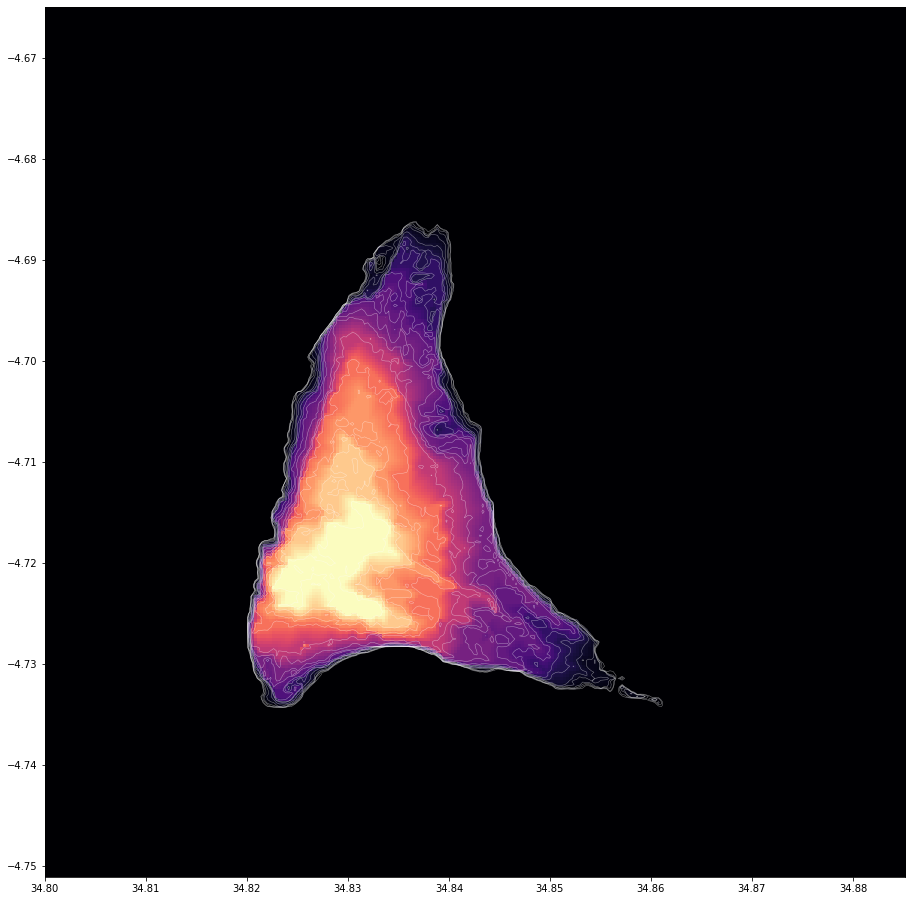

In [10]:
# Extract x, y and z points for interpolation
all_contours = contours_to_arrays(gdf=gdf, col='in_perc')
points_xy = all_contours[:, [1, 0]]
values_elev = all_contours[:, 2]

# Create grid to interpolate into
x_size, _, upleft_x, _, y_size, upleft_y =  landsat_dataset.geobox.transform[0:6]
xcols = len(landsat_dataset.longitude)
yrows = len(landsat_dataset.latitude)
bottomright_x = upleft_x + (x_size * xcols)
bottomright_y = upleft_y + (y_size * yrows)
yrows, xcols = landsat_dataset.red.shape[1:]
grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * yrows, upleft_x:bottomright_x:1j * xcols]

# Interpolate x, y and z values using linear/TIN interpolation
out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

# Set areas outside of NDWI composites to highest innundation percentage
test = (combined.mndwi > 0).max(dim='inundation_perc')
out[~test] = np.nanmax(out)
out[np.isnan(out)] = np.nanmax(out)

# Apply guassian blur to smooth transitions between z values (optional)
out = filters.gaussian(out, sigma=guassian_sigma)
out = exposure.rescale_intensity(out, out_range=(timeseries_subset.min().item() - 0.001, 
                                                 timeseries_subset.max().item() + 0.001))

# Plot interpolated surface
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(out, cmap='magma_r', extent=[upleft_x, bottomright_x, bottomright_y, upleft_y])
gdf.plot(ax=ax, edgecolor='white', linewidth=0.5, alpha=0.5)

## Export DEM and RGB arrays to file

In [11]:
kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 1,
         'dtype': rasterio.float64,
         'crs': 'EPSG:4326',
         'transform': landsat_dataset.geobox.transform,
         'nodata': -9999}

with rasterio.open('GA_outputs/{}_dem.tif'.format(name), 'w', **kwargs) as target:
    target.write_band(1, out)

In [12]:
# Select a single cloud free image  with low inundation
data_array = landsat_dataset.sel(time = (landsat_dataset.data_perc > 0.9) & 
             (landsat_dataset.inundation_perc < 0.2)).mean(dim='time')[['red', 'green', 'blue']].to_array().values

# Optimise colours using a percentile stretch
rgb_array = np.transpose(data_array, [1, 2, 0])
p_low, p_high = np.nanpercentile(rgb_array, [2, 98])
img_toshow = exposure.rescale_intensity(rgb_array, in_range=(p_low, p_high), out_range=(0, 1))

# Change dtype to int16 scaled between 0 and 10000 to save disk space
img_toshow = (img_toshow * 10000).astype(rasterio.int16)

kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 3,
         'dtype': rasterio.int16,
         'crs': 'EPSG:4326',
         'transform': landsat_dataset.geobox.transform,
         'nodata': -9999}

with rasterio.open('GA_outputs/{}_rgb.tif'.format(name), 'w', **kwargs) as target:
    target.write(np.transpose(img_toshow, [2, 0, 1]))